<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <p style=" text-align: center; font-size: 32px;">   
   <strong>Pricing Call Options with Discrete Dividends Using Stochastic Expansions and Monte Carlo Methods  </strong></p>
    <p style=" text-align: center; font-size: 25px;"><strong> Master Probabilities & Finance - Ecole Polytechnique and Sorbonne University <strong></p>
  <p style=" text-align: center; font-size: 20px;">Constantin GLEYZE</p>
</header>

This notebook implements and compares three methods for pricing Call Options with discrete dividends, where the dividends are modeled as having both fixed and proportional components. The date for the dividends can be random, as well as the level of the dividends. 

- A Monte Carlo approach simulating the full underlying asset paths including discrete dividends,
- A Monte Carlo approach simulating only the underlying asset price at maturity with discrete dividends,
- Stochastic expansions of the Call option price with discrete dividends up to orders 1, 2, and 3.

For the first two methods, we also added an adaptative anthitetic variance reduction algorithm to improve the convergence. 


> **The specific stochastic expansions are from the following paper:**  
> Pierre Etoré, Emmanuel Gobet. Stochastic expansion for the pricing of call options with discrete
dividends. Applied Mathematical Finance, 2012, 19 (3), pp.233-264. ff10.1080/1350486X.2011.620397ff.
ffhal-00507787f

The proofs of all the results and theorems used in this notebook can be found in the paper above.



<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Introduction<h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">1. Underlying dynamic and diffusion equations <h1>

<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>


Let $(\Omega,\mathcal F,(\mathcal F_t)_{t\ge0},\mathbb{Q})$ support a standard Brownian motion $W$.  
Under the risk-neutral measure $\mathbb{Q}$ the price without discrete dividend $S_t$ at time $t$ solves
$$
  dS_t=S_t(r-\delta)dt+S_t\sigma\,dW_t,\qquad S_0>0,
$$
with short rate $r$, continuous dividend yield $\delta$, and volatility $\sigma>0$.

We now consider an underlying paying discrete dividend $(S_{t}^{(y, \delta)})_{t \in [0,T]}$. 

This stochastic process still follows the dynamic: 

$$
  dS_{t}^{(y, \delta)}=S_{t}^{(y, \delta)}(r-\delta)dt+S_{t}^{(y, \delta)}\sigma\,dW_t,\qquad S_{0}^{(y, \delta)}>0,
$$

At each dividend date $t_i$, the asset price drops by a fixed amount $\delta_i$ and a proportional amount $y_i$ of its value just before the dividend. 

The amount of dividend is then given by: $$\delta_i + y_i S_{t_i^-}^{(y, \delta)}$$

The new asset price immediately after the dividend is given by:


$$S_{t_i}^{(y, \delta)} = S_{t_i^-}^{(y, \delta)} (1 - y_i) - \delta_i$$

Using the previous definitions, the asset price with discrete proportional and fixed dividends evolves according to the following piecewise rule:

$$
S_t^{(y, \delta)} =
\begin{cases}
S_t & \text{if } t < t_1, \\
(1 - y_i) S_{t_i^-}^{(y, \delta)} \cdot \frac{S_t}{S_{t_i}} - \delta_i \cdot \frac{S_t}{S_{t_i}} & \text{if } t_i \leq t < t_{i+1} \text{ for } i < n, \\
(1 - y_i) S_{t_i^-}^{(y, \delta)} \cdot \frac{S_t}{S_{t_i}} - \delta_i \cdot \frac{S_t}{S_{t_i}} & \text{if } t_i \leq t \leq T \text{ for } i = n.
\end{cases}
$$

We now introduce the following notation: 

$\pi_{i,n} := \prod_{j=i+1}^{n} (1 - y_j), \quad \text{with } \pi_{n,n} = 1$


We then can prove that: 

$$S_T^{(y, \delta)} = \pi_{0,n} S_T - \sum_{i=1}^{n} \delta_i \pi_{i,n} \frac{S_T}{S_{t_i}}$$


<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">2. Creation of our proxy for the Taylor expansion <h1>

<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>


For the use of convenience, we introduce the following notation: 

- We write the discount factor: $D_t = \exp\left( - \int_0^t (r_s - q_s) ds \right)$
  
- The log-normal martingale: $M_t = \exp\left( \int_0^t \sigma_s dW_s - \frac{1}{2} \int_0^t \sigma_s^2 ds \right)$
  
- The shifted discrete dividend: $\hat{\delta}_i = \delta_i \pi_{i,n} \frac{D_{t_i}}{D_T}$
  
- The shifted strike: $K^{(y, \delta)} = K + \sum_{i=1}^{n} \delta_i \pi_{i,n} \frac{D_{t_i}}{D_T} = K + \sum_{i=1}^{n} \hat{\delta}_i$

The proxy is given by: 

$$\bar{S}_T^{(y, \delta)} := \pi_{0,n} S_T - \mathbb{E}\left[ \sum_{i=1}^{n} \delta_i \pi_{i,n} \frac{S_T}{S_{t_i}} \right] = \pi_{0,n} S_T - \sum_{i=1}^{n} \delta_i \pi_{i,n} \frac{D_{t_i}}{D_T} = \pi_{0,n} S_T - \sum_{i=1}^{n} \hat{\delta}_i$$

The specific call formula for our proxy is: 

$$\mathbb{E}\left[ e^{- \int_0^T r_s ds} \left( \bar{S}_T^{(y, \delta)} - K \right)^+ \right] = \text{Call}^{BS}\left( \pi_{0,n} S_0, K^{(y, \delta)} \right)$$

<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">3. Taylor expansions <h1>

<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>


We have the following relationship between our underlying and the proxy: 

$$S_T^{(y, \delta)} = S_T^{(y, 0)} - \sum_{i=1}^{n} \delta_i \pi_{i,n} \frac{D_{t_i}}{D_T} \left( 1 + \frac{M_T}{M_{t_i}} - 1 \right) = \bar{S}_T^{(y, \delta)} - \sum_{i=1}^{n} \hat{\delta}_i \left( \frac{M_T}{M_{t_i}} - 1 \right)$$

The goal is to approximate $\mathbb{E}\left(e^{-\int_0^T r_s \, ds} h\big(S(y,\delta)_T - K\big)\right)$ for $h(x) = x^+ $

We introduce the $k^{th}$ smoothness condition for h: 

$(H_k):$ The functionh $h(\cdot)$ is $(k - 1)$-times continuously differentiable and the $(k-1)$-th derivative is almost everywhere differentiable. Moreover, the derivatives are polynomially bounded: for some positive constants $C$ and $p$ one has $|h(x)| + \sum_{j=1}^k |\partial_x^j h(x)| \leq C(1 + |x|^p)$ for any $x \in \mathbb{R}$

We now present the main theorem of the paper which stand for the function of the call's payoff $h : x \mapsto \max(x, 0)$: 

#### 3.1. Second order expansion

**Theorem 3.1 (2.2 in the paper):** For a smooth function $h$ satisfying $(H_3)$, we have

$$
\begin{align*}
\mathbb{E}\left[ e^{-\int_0^T r_s \, ds} \, h\big(S^{(y,\delta)}_T - K\big) \right]
&= \mathbb{E}\left[ e^{-\int_0^T r_s \, ds} \, h\big(\pi_{0,n} S_T - K^{(y,\delta)}\big) \right] \\
&\quad + \sum_{i=1}^n \hat{\delta}_i \Bigg[
\partial_k \mathbb{E}\left[ e^{-\int_0^T r_s \, ds} \, h\left(\pi_{0,n} e^{\int_{t_i}^T \sigma_s^2 ds} S_T - k \right) \right] \Bigg|_{k = K^{(y,\delta)}} \\
&\qquad - \partial_k \mathbb{E}\left[ e^{-\int_0^T r_s \, ds} \, h\big( \pi_{0,n} S_T - k \big) \right] \Bigg|_{k = K^{(y,\delta)}} \Bigg] \\
&\quad + \frac{1}{2} \sum_{1 \leq i,j \leq n} \hat{\delta}_i \hat{\delta}_j \,
\partial_k^2 \mathbb{E}\left[ e^{-\int_0^T r_s \, ds} \, h\left( \pi_{0,n} e^{\int_{t_i}^T \sigma_s^2 ds + \int_{t_j}^T \sigma_s^2 ds} S_T - k \right) \right] 
e^{\int_{t_i \vee t_j}^T \sigma_s^2 ds} \Bigg|_{k = K^{(y,\delta)}} \\
&\quad - 2 \left( \sum_{j=1}^n \hat{\delta}_j \right) \left( \sum_{i=1}^n \hat{\delta}_i 
\partial_k^2 \mathbb{E}\left[ e^{-\int_0^T r_s \, ds} \, h\left( \pi_{0,n} e^{\int_{t_i}^T \sigma_s^2 ds} S_T - k \right) \right] \Bigg|_{k = K^{(y,\delta)}} \right) \\
&\quad + \left( \sum_{j=1}^n \hat{\delta}_j \right)^2
\partial_k^2 \mathbb{E}\left[ e^{-\int_0^T r_s \, ds} \, h\left( \pi_{0,n} S_T - k \right) \right] \Bigg|_{k = K^{(y,\delta)}} \\
&\quad + \text{Error}_3(h)
\end{align*}
$$


$\text{with} \quad |\text{Error}_3(h)| \leq c (1 + S_0^p) \sup_i \left(\delta_i \sigma \sqrt{, \space c\in \mathbb{R_+^*}. - t_i}\right)^3.$


<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">4. Taylor expansions applied to Call options <h1>

<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>

In addition, for some of our results we may assume that for the first dividend date, the ratio is small enough in the sense

$$
\frac{\delta_1}{S_0(1 - y_1)} < 1. \space \space \space \space \textbf{    (D)}
$$

We also impose a non-degeneracy condition on the model (ellipticity condition):

$$
\forall t \in [0, T], \quad 0 < \underline{\sigma} \leq \sigma_t \leq \overline{\sigma}. \space \space \space \space \textbf{    (E)}
$$


We now describe the Taylor expansions for the specific case of the Call options at the order 1, 2 and 3. The three order expansion is derived from the second one. 

#### 4.1. First order expansion 

**Theorem 4.1 (2.3 in the paper):** 

Assume **(D)** and **(E)**. We have:

$$
\begin{align*}
\mathbb{E}\left[ e^{-\int_0^T r_s \, ds} \, \left(S_T^{(y,\delta)} - K\right)^+ \right]
&= \text{Call}_{\text{BS}}\left(\pi_{0,n} S_0,\, K^{(y,\delta)}\right) \\
&\quad + \sum_{i=1}^n \hat{\delta}_i \left[
\partial_K \text{Call}_{\text{BS}}\left(\pi_{0,n} S_0 \, e^{\int_{t_i}^T \sigma_s^2 ds},\, K^{(y,\delta)}\right)
- \partial_K \text{Call}_{\text{BS}}\left(\pi_{0,n} S_0,\, K^{(y,\delta)}\right)
\right] \\
&\quad + \text{Error}_2(\text{Call})
\end{align*}
$$

with

$
\left| \text{Error}_2(\text{Call}) \right| \leq c \, \sup_i \left( \delta_i S_0 \sqrt{1 - \frac{t_i}{T}} \right)^2 \, \sigma \sqrt{T}, \space c\in \mathbb{R_+^*}.
$

#### 4.2. Second order expansion 

**Theorem 4.2 (2.4 in the paper):** 

Assume **(D)** and **(E)**. We have:

$$
\begin{align*}
\mathbb{E}\left[ e^{-\int_0^T r_s \, ds} \, \left(S_T^{(y,\delta)} - K\right)^+ \right]
&= \text{Call}_{\text{BS}}\bigl( \pi_{0,n} S_0,\, K^{(y,\delta)} \bigr) \\
&\quad + \sum_{i=1}^n \hat{\delta}_i \left(
\partial_k \text{Call}_{\text{BS}}\bigl( \pi_{0,n} S_0 \, e^{\int_{t_i}^T \sigma_s^2 ds},\, K^{(y,\delta)} \bigr)
- \partial_K \text{Call}_{\text{BS}}\bigl( \pi_{0,n} S_0,\, K^{(y,\delta)} \bigr)
\right) \\
&\quad + \frac{1}{2} \sum_{1 \leq i,j \leq n} \hat{\delta}_i \hat{\delta}_j \,
e^{\int_{t_i \vee t_j}^T \sigma_s^2 ds} \,
\partial_K^2 \text{Call}_{\text{BS}}\bigl( \pi_{0,n} S_0 \, e^{\int_{t_i}^T \sigma_s^2 ds + \int_{t_j}^T \sigma_s^2 ds},\, K^{(y,\delta)} \bigr) \\
&\quad - 2 \sum_{j=1}^n \hat{\delta}_j \left( \sum_{i=1}^n \hat{\delta}_i \,
\partial_K^2 \text{Call}_{\text{BS}}\bigl( \pi_{0,n} S_0 \, e^{\int_{t_i}^T \sigma_s^2 ds},\, K^{(y,\delta)} \bigr) \right) \\
&\quad + \sum_{j=1}^n \hat{\delta}_j^2 \,
\partial_K^2 \text{Call}_{\text{BS}}\bigl( \pi_{0,n} S_0,\, K^{(y,\delta)} \bigr) \\
&\quad + \text{Error}_3(\text{Call})
\end{align*}
$$


with

$
\left| \text{Error}_3(\text{Call}) \right| \leq c \, \sup_i \left( \delta_i S_0 \sqrt{1 - \frac{t_i}{T}} \right)^3 \, \sigma \sqrt{T}, \space c\in \mathbb{R_+^*}.
$


#### 4.3. Third order expansion 

**Theorem 4.3. (2.5 in the paper):** 

Assume **(D)** and **(E)**. We have:


$$
\begin{aligned}
\mathbb{E}\left[ e^{-\int_0^T r_s \, ds} \left(S_T^{(y,\delta)} - K\right)^+ \right]
&= \text{Call}_{\text{BS}}\bigl( \pi_{0,n} S_0,\, K^{(y,\delta)} \bigr) \\
&\quad + \sum_{i=1}^n \hat{\delta}_i \left(
\partial_K \text{Call}_{\text{BS}}\bigl( \pi_{0,n} S_0 e^{\int_{t_i}^T \sigma_s^2 ds},\, K^{(y,\delta)} \bigr)
- \partial_K \text{Call}_{\text{BS}}\bigl( \pi_{0,n} S_0,\, K^{(y,\delta)} \bigr)
\right) \\
&\quad + \frac{1}{2} \sum_{1 \leq i,j \leq n} \hat{\delta}_i \hat{\delta}_j \, 
e^{\int_{t_i \vee t_j}^T \sigma_s^2 ds} \,
\partial_K^2 \text{Call}_{\text{BS}}\bigl( \pi_{0,n} S_0 \, e^{\int_{t_i}^T \sigma_s^2 ds + \int_{t_j}^T \sigma_s^2 ds},\, K^{(y,\delta)} \bigr) \\
&\quad - 2 \sum_{j=1}^n \hat{\delta}_j \left( \sum_{i=1}^n \hat{\delta}_i \,
\partial_K^2 \text{Call}_{\text{BS}}\bigl( \pi_{0,n} S_0 \, e^{\int_{t_i}^T \sigma_s^2 ds},\, K^{(y,\delta)} \bigr) \right) \\
&\quad + \sum_{j=1}^n \hat{\delta}_j^2 \,
\partial_K^2 \text{Call}_{\text{BS}}\bigl( \pi_{0,n} S_0,\, K^{(y,\delta)} \bigr) \\
&\quad + \frac{1}{6} \sum_{1 \leq i,j,l \leq n} \hat{\delta}_i \hat{\delta}_j \hat{\delta}_l \,
e^{\int_{t_i \vee t_j}^T \sigma_s^2 ds + \int_{t_i \vee t_l}^T \sigma_s^2 ds + \int_{t_j \vee t_l}^T \sigma_s^2 ds} \\
&\qquad \times \partial_K^3 \text{Call}_{\text{BS}}\bigl( \pi_{0,n} S_0 e^{\int_{t_i}^T \sigma_s^2 ds + \int_{t_j}^T \sigma_s^2 ds + \int_{t_l}^T \sigma_s^2 ds},\, K^{(y,\delta)} \bigr) \\
&\quad - 3 \sum_{j=1}^n \hat{\delta}_j \left( \sum_{1 \leq i,l \leq n} \hat{\delta}_i \hat{\delta}_l \,
e^{\int_{t_i \vee t_l}^T \sigma_s^2 ds} \,
\partial_K^3 \text{Call}_{\text{BS}}\bigl( \pi_{0,n} S_0 e^{\int_{t_i}^T \sigma_s^2 ds + \int_{t_l}^T \sigma_s^2 ds},\, K^{(y,\delta)} \bigr) \right) \\
&\quad + 3 \sum_{j=1}^n \hat{\delta}_j^2 \left( \sum_{i=1}^n \hat{\delta}_i \,
\partial_K^3 \text{Call}_{\text{BS}}\bigl( \pi_{0,n} S_0 e^{\int_{t_i}^T \sigma_s^2 ds},\, K^{(y,\delta)} \bigr) \right) \\
&\quad - \sum_{j=1}^n \hat{\delta}_j^3 \,
\partial_K^3 \text{Call}_{\text{BS}}\bigl( \pi_{0,n} S_0,\, K^{(y,\delta)} \bigr) \\
&\quad + \text{Error}_4(\text{Call})
\end{aligned}
$$

With 
$
\left| \text{Error}_4(\text{Call}) \right|
\leq c \, S_0 \, \sigma \, \sqrt{T} \cdot \sup_i \left( \left| \frac{\delta_i}{S_0} \, \sqrt{1 - \frac{t_i}{T}} \right|^4 \right), \space c\in \mathbb{R_+^*}.
$

<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">5. Variance Reduction Method <h1>

<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>

**1. Theoretical approach**

We define $X$ and $X'$ that are identically distributed such that: 
$$
\mathbb{E}[X]=\mathbb{E}[X']=m_X,\quad
\mathrm{Var}[X]=\mathrm{Var}[X']=\sigma_X^2,
$$

but $\mathrm{Var}[X-X']>0$, and we set
$$
\Xi \;=\; X - X'.
$$

We introduce a dynamic control variate $\lambda$ and we set: 
$$
X^{\lambda} \;=\; X \;-\;\lambda\,\Xi,
$$

The variance of $X^{\lambda}$ is minimized when
$$
\lambda_{\min}
=\frac{\operatorname{Cov}(X,\Xi)}{\operatorname{Var}(\Xi)}.
$$

We compute the sample mean of the controlled payoffs, using an estimator $\hat\lambda_{min}$ for $\lambda_{min}$:

$$
\overline{X}_n^{\hat\lambda_{min}}
=\overline{X}_n + \hat\lambda^{min}_n\,\overline{\Xi}_n,
$$
where

$$
\overline{X}_n
=\frac{1}{n}\sum_{k=1}^n X_k,
\qquad
\hat\lambda^{min}_n
=\frac{\displaystyle\frac{1}{n}\sum_{k=1}^n X_k\,(X_k - X_k')}
     {\displaystyle\frac{1}{n}\sum_{k=1}^n (X_k - X_k')^2},
\qquad
\overline{\Xi}_n
=\frac{1}{n}\sum_{k=1}^n (X_k - X_k').
$$

We have: 

$$
\sqrt{n}\,\bigl(\overline{X}_n^{\hat\lambda_{min}}-m_X\bigr)
\;\xrightarrow{\mathcal{L}}\;
\mathcal{N}\bigl(0,\sigma^2_{\min}\bigr)
\quad\text{as }n\to+\infty,
$$
or equivalently
$$
\overline{X}_n^{\lambda}-m_X
\;\xrightarrow{\mathcal{L}}\;
\mathcal{N}\!\Bigl(0,\tfrac{\sigma^2_{\min}}{n}\Bigr)
\quad\text{as }n\to+\infty,
$$
with
$$
\sigma^2_{\min}\;\le\;\sigma_X^2.
$$

However our estimator is biaised. Indeed, in practice:

$$
\mathbb{E}\bigl[\overline{X}_n^{\hat\lambda_{min}}\bigr]
= m_X \;-\; \mathbb{E}\bigl[\hat\lambda_n^{min}\,\overline{\Xi}_n\bigr], \space \space \space \mathbb{E}\bigl[\hat\lambda_n^{min}\,\overline{\Xi}_n\bigr]\neq 0,
$$



Then: 

$$
\mathbb{E}\bigl[\overline{X}_n^{\hat\lambda_{min}}\bigr]
\neq
 m_.
$$

To manage this issue, we use the adaptative approach. We define for each \(k\):
$$
\widetilde X_k \;=\; X_k \;-\;\widetilde\lambda_{k-1}\,\Xi_k,
$$
where
$$
\widetilde\lambda_k \;=\;\bigl(-k)\vee\bigl(\hat\lambda_n^{min}\wedge k\bigr),
$$

Our estimator is then:
$$
\overline{\widetilde X}_n
\;=\;\frac{1}{n}\sum_{k=1}^n \widetilde X_k
\;=\;\overline X_n
\;-\;\frac{1}{n}\sum_{k=1}^n\widetilde\lambda_{k-1}\,\Xi_k,
$$

This estimator satisfies (See G.~Pagès, Numerical Probability, §3.2.2):

- **Unbiasedness:** $\mathbb{E}\bigl[\overline{\widetilde X}_n\bigr]=m_X.$
- **Almost sure convergence:** $\overline{\widetilde X}_n \xrightarrow{\mathrm{a.s.}} m_X \quad\text{as }n\to+\infty.$
- **Asymptotic normality:** $\sqrt{n}\,\bigl(\overline{\widetilde X}_n - m_X\bigr) \xrightarrow{\mathcal{L}} \mathcal{N}\bigl(0,\sigma_{\min}^2\bigr) \quad\text{as }n\to+\infty.$
 
Then the adaptive estimator of $m$, defined by
$$
\widetilde X_M^{\lambda}
=\frac{1}{M}\sum_{k=1}^M\widetilde X_k,
$$
is unbiased 
$$
\mathbb{E}\bigl[\widetilde X_M^{\lambda}\bigr]=m,
$$
convergent, i.e.
$$
\widetilde X_M^{\lambda}\xrightarrow{\mathrm{a.s.}}m
\quad\text{as }M\to+\infty,
$$
and asymptotically normal with minimal variance, i.e.
$$
\sqrt{M}\,\bigl(\widetilde X_M^{\lambda}-m\bigr)
\xrightarrow{\mathcal{L}}
\mathcal{N}\bigl(0,\sigma_{\min}^2\bigr)
\quad\text{as }M\to+\infty.
$$

**2. Empirical application**

We perform only one simulation of $N\times M$ standard normal draws, corresponding to $N$ paths each discretized in $M$ steps.  

First, generate
$$
(W^i_j)_{%
  i=1,\dots,N,\; j=1,\dots,M}
\quad\text{drawn i.i.d with}\quad W^i_j\sim\mathcal{N}(0,1),
$$

and use these to build the price matrix $S_1^{(y,\delta)}$.  Then construct a second matrix $S_2^{(y,\delta)}$ by replacing each normal draw with its negation, $-W^i_j$.  The two matrices $S_1^{(y,\delta)}$ and $S_2^{(y,\delta)}$ are identically distributed, and combining their payoffs will reduce variance via antithetic pairing.


For each path $i$ in $S_1^{(y,\delta)}$, apply the chosen pricing algorithm to obtain the non-discounted payoff
$$
X_{1,i}^{(y,\delta)} \;=\;\mathrm{Payoff}\bigl(S_{1,i}^{(y,\delta)},T\bigr),
$$
and similarly from $S_2^{(y,\delta)}$ obtain
$$
X_{2,i}^{(y,\delta)} \;=\;\mathrm{Payoff}\bigl(S_{2,i}^{(y,\delta)},T\bigr),
$$

We then form the adaptively antithetic combined payoff $\overline{X}$ such that: 

$$
\overline{X}_i
=X_{1,i}^{(y,\delta)}
\;-\;\hat\lambda^{\min}_{i-1}(X_{1,i}^{(y,\delta)}-X_{2,i}^{(y,\delta)}) 
$$


Finally, the option price is estimated by the discounted average of these adjusted payoffs:
$$
\widehat P
= e^{-(r-q)T}\,\frac1M\sum_{i=1}^{M}\overline{X}_i.
$$

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">1. Common functions<h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [1]:
from numba import njit, prange
import numba.np.random as nbrandom
import numpy as np 
import time
import gc
from scipy.stats import norm
from numba import config
from IPython.display import display, HTML
from numba import njit, prange
import numba.np.random as nbrandom
import matplotlib.lines as mlines
import numpy as np 
import time
import matplotlib.pyplot as plt
import gc

<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">1.1. Internal functions <h1>

<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>

In [2]:
def get_divs_values(T, t1, diff, fixed_divs, proportional_divs):

    """
    Notes
    -----
    Generate dividend payment timestamps and corresponding dividend values arrays.

    Parameters
    ----------
    T : int
        Number of dividend payments.
    t1 : float
         Initial time offset for the first dividend.
    diff : float, int, or iterable
           If float/int, uniform spacing between dividends. 
           If iterable, explicit list/array of time differences added to t1.
    fixed_divs : float, int, or iterable
                 Fixed dividend amounts; either scalar (applied to all) or list matching length T.
    proportional_divs : float, int, or iterable
                        Proportional dividend amounts; scalar or list matching length T.

    Returns
    -------
    divs_value : ndarray
                 Array of shape (T, 2) stacking proportional and fixed dividends per payment.
    ts_divs : ndarray
              Dividend payment times of length T.
    """

    # Build dividend timestamps array
    if isinstance(diff, (float, int)): 
        ts_divs = np.array([t1 + diff*i for i in range(T)], dtype=np.float32)
    else: 
        ts_divs = np.array([t1 + i for i in diff], dtype=np.float32)

    # Validation of fixed_divs length if iterable
    if not isinstance(fixed_divs, (float, int)) and len(fixed_divs) != len(ts_divs):
        raise ValueError("fixed_divs must have same length as ts_divs")

    # Validation of proportional_divs length if iterable
    if not isinstance(proportional_divs, (float, int)) and len(proportional_divs) != len(ts_divs):
        raise ValueError("proportional_divs must have same length as ts_divs")

    # Create fixed dividends array, broadcast if scalar
    if isinstance(fixed_divs, (float, int)): 
        fixed_divs_list = np.full(len(ts_divs), fixed_divs, dtype=np.float32)
    else: 
        fixed_divs_list = np.array(fixed_divs, dtype=np.float32)

    # Create proportional dividends array, broadcast if scalar
    if isinstance(proportional_divs, (float, int)): 
        proportional_divs_list = np.full(len(ts_divs), proportional_divs, dtype=np.float32)
    else: 
        proportional_divs_list = np.array(proportional_divs, dtype=np.float32)

    return np.column_stack((proportional_divs_list, fixed_divs_list)), ts_divs # Stack proportional and fixed dividends column-wise

@njit(cache=True)
def adaptive_antithetic_algo(X1, theta, r,q, T):

    """
    Notes
    -----
    Adaptive Monte Carlo estimator using antithetic variates to reduce variance.

    This online algorithm estimates the optimal control variate coefficient lambda adaptively,
    updating the estimator after each new sample.

    Parameters
    ----------
    X1 : ndarray
         Array of Monte Carlo payoff samples.
    theta : ndarray
            Array of antithetic variate differences (X1 - X2).
    r : float
        Risk-free interest rate.
    q : float
        Dividend yield.
    T : float
        Time to maturity.

    Returns
    -------
    price_estimate : float
                     Discounted estimated option price after adaptive control variate adjustment.
    var_estimator : float
                    Variance estimate of the discounted estimator.
    """
    
    N = len(X1) # Number of samples
    estimator = np.zeros(N) # Running estimator array
    theta_sum = 0. # Cumulative sum of theta
    X1_sum = 0. # Cumulative sum of X1
    X1_theta_sum = 0. # Cumulative sum of X1 * theta
    theta_square_sum = 0  # Cumulative sum of theta^2
    lambda_batch = 0 # Batch estimation of lambda
    new_lambda_adaptative = 0. # Adaptive lambda updated online

    epsilon = 1e-8  # Numerical stability threshold

    # Initialize lambda adaptively based on first sample
    if abs(theta[0]) < 1e-8:
        previous_lambda_adaptative = 0.0
    else:
        previous_lambda_adaptative = X1[0] / theta[0]

    # Online update for each sample
    for j in range (0,N): 
        i=j+1 # Iteration count (starts at 1)

        # Update cumulative sums
        theta_sum+= theta[j]
        X1_sum+=X1[j]
        X1_theta_sum += X1[j]*theta[j]
        theta_square_sum += theta[j]**2

        # Update batch lambda estimate
        if theta_square_sum==0.: 
            lambda_batch=0.
        else : 
            lambda_batch= X1_theta_sum/theta_square_sum
        
        new_lambda_adaptative = np.maximum(np.minimum(i,lambda_batch),-i) # Clamp the adaptive lambda to avoid explosion
        
        estimator[j] =  X1_sum/i - previous_lambda_adaptative*theta_sum/i # Update estimator with current adaptive lambda
        previous_lambda_adaptative = new_lambda_adaptative # Prepare lambda for next iteration

    discount = np.exp(-(r-q) * T) # Discount final estimator
    return discount * estimator[-1], np.var(discount*estimator)

<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">1.2. Display functions <h1>

<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def build_summary_table(t_list, K_list, payoff_id, n_paths, ts_paths, S0, r, q, vol, T, diff, fixed_divs, proportional_divs, rng=None, digits=4):
    
    """
    Builds a summary table (pandas DataFrame) comparing different option pricing methods
    for multiple maturities and strikes, including Monte Carlo simulations and Taylor expansions.

    Parameters
    ----------
    t_list : list of float
             List of maturities to evaluate (e.g. [0.1, 0.5, 0.9]).
    K_list : list of float
             List of strike prices to evaluate (e.g. [70, 100, 130]).
    payoff_id : str
                Payoff type identifier (e.g. "Call", "Put").
    n_paths : int
              Number of Monte Carlo paths to simulate.
    ts_paths : array-like
               Time steps grid used in path simulations.
    S0 : float
         Initial underlying price.
    r : float
        Risk-free interest rate (continuously compounded).
    q : float
        Continuous dividend yield.
    vol : float
          Volatility of the underlying asset.
    T : float
        Final maturity time (in years).
    diff : float or list
           Time difference or list of dividend time offsets after t1.
    fixed_divs : float or list
                 Fixed dividend amounts.
    proportional_divs : float or list
                        Proportional dividend amounts (fractions).
    rng : numpy.random.Generator or None, optional
          Random number generator instance for reproducibility.
    digits : int, optional
             Number of decimals for formatting prices and intervals.

    Returns
    -------
    None
        Displays a styled pandas DataFrame summarizing prices, confidence intervals, variance, and timing.
    """

    rows = []
    for t in t_list:
        j = 0
        divs_value, ts_divs = get_divs_values(T, t, diff, fixed_divs, proportional_divs)
        for K in K_list:
            # Prepare row starting with maturity (only once per maturity) and strike
            row = [f"{t:.2f}" if j == 0 else '', K]

            timing = []

            # Monte Carlo with full path simulation
            start = time.perf_counter()
            price_full, var_full = get_MC_estimator_from_complete_paths(payoff_id, n_paths, ts_paths, S0, r, q, vol, K, ts_divs, divs_value, rng)
            end = time.perf_counter()
            timing.append(f"{end - start:.3f}s")

            # Monte Carlo simulating only last price
            start = time.perf_counter()
            price_last, var_last = get_MC_price_with_last_price(payoff_id, K, n_paths, S0, r, q, vol, T, ts_divs, divs_value, rng)
            end = time.perf_counter()
            timing.append(f"{end - start:.3f}s")

            # Taylor expansion orders 1, 2, and 3
            start = time.perf_counter()
            price_taylor_1 = Taylor_expansion_call_BS_divs(S0, T, K, r, q, vol, divs_value, ts_divs, order=1)
            end = time.perf_counter()
            timing.append(f"{end - start:.3f}s")

            start = time.perf_counter()
            price_taylor_2 = Taylor_expansion_call_BS_divs(S0, T, K, r, q, vol, divs_value, ts_divs, order=2)
            end = time.perf_counter()
            timing.append(f"{end - start:.3f}s")

            start = time.perf_counter()
            price_taylor_3 = Taylor_expansion_call_BS_divs(S0, T, K, r, q, vol, divs_value, ts_divs, order=3)
            end = time.perf_counter()
            timing.append(f"{end - start:.3f}s")

            # Calculate 95% confidence intervals for MC estimates
            ci_full = 1.96 * np.sqrt(var_full) / np.sqrt(n_paths)
            ci_last = 1.96 * np.sqrt(var_last) / np.sqrt(n_paths)

            # Append formatted results to the row
            row.append(f"{price_full:.{digits}f} (±{ci_full:.{digits}e})")
            row.append(f"{var_full:.2e}")
            row.append(timing[0])
            row.append(" ")  # spacing column
            row.append(f"{price_last:.{digits}f} (±{ci_last:.{digits}e})")
            row.append(f"{var_last:.2e}")
            row.append(timing[1])
            row.append(" ")
            row.append(f"{price_taylor_3:.{digits}f}")
            row.append(timing[-1])
            row.append(" ")
            row.append(f"{price_taylor_2:.{digits}f}")
            row.append(timing[-2])
            row.append(" ")
            row.append(f"{price_taylor_1:.{digits}f}")
            row.append(timing[-3])

            rows.append(row)
            j += 1

    # Prepare the columns of the Dataframe
    columns = [
        't', 'K',
        'MC full paths (±error)', 'Variance', 'Time', '',
        'MC last price (±error)', 'Variance', 'Time', '',
        'Taylor 3', 'Time', '',
        'Taylor 2', 'Time', '',
        'Taylor 1', 'Time'
    ]

    # Adjust according to the parameters the title of the table 
    df = pd.DataFrame(rows, columns=columns)
    title = (f"Pricing {payoff_id} with discrete dividends using Monte Carlo (full paths, last price) "
             f"and Taylor expansions (orders 3, 2, 1)\n"
             f"(S0={S0}, r={r*100:.2f}%, q={q*100:.2f}%, T={T}, σ={vol*100:.2f}%, paths={n_paths:,}, "
             f"time steps={len(ts_paths):,}, fixed div={fixed_divs}, prop div={proportional_divs}, "
             f"dividend times start at t={t} with step {diff})")

    styles = [
        dict(selector="th", props=[("text-align", "center"), ("padding", "8px")]),
        dict(selector="td", props=[("text-align", "center"), ("padding", "8px")]),
        dict(selector="caption", props=[("caption-side", "top"), ("font-weight", "bold"), ("font-size", "16px"),
                                       ("text-align", "center"), ("margin-bottom", "10px")])
    ]

    styled_df = df.style.set_table_styles(styles).set_caption(title).hide(axis='index')
    display(styled_df)


def print_convergence(n_paths_list, t, K, payoff_id, ts_paths, S0, r, q, vol, T, diff, fixed_divs, proportional_divs, rng=None):
    
    """
    Plots the convergence of Monte Carlo estimates (full path and last price) versus number of paths,
    alongside Taylor expansion prices for comparison.

    Parameters
    ----------
    n_paths_list : list or array of int
                   List of numbers of Monte Carlo paths to test.
    t : float
        Starting dividend time.
    K : float
        Strike price.
    payoff_id : str
                Payoff type identifier.
    ts_paths : array-like
               Time steps grid used in path simulations.
    S0 : float
         Initial underlying price.
    r : float
        Risk-free interest rate (continuously compounded).
    q : float
        Continuous dividend yield.
    vol : float
          Volatility of the underlying asset.
    T : float
        Final maturity time (in years).
    diff : float or list
           Time difference or list of dividend time offsets after t1.
    fixed_divs : float or list
                 Fixed dividend amounts.
    proportional_divs : float or list
                        Proportional dividend amounts (fractions).
    rng : numpy.random.Generator or None, optional
          RNG instance for reproducibility.

    Returns
    -------
    None
        Displays a convergence plot.
    """

    divs_value, ts_divs = get_divs_values(T, t, diff, fixed_divs, proportional_divs)

    # Taylor prices at different orders
    price_taylor_1 = Taylor_expansion_call_BS_divs(S0, T, K, r, q, vol, divs_value, ts_divs, order=1)
    price_taylor_2 = Taylor_expansion_call_BS_divs(S0, T, K, r, q, vol, divs_value, ts_divs, order=2)
    price_taylor_3 = Taylor_expansion_call_BS_divs(S0, T, K, r, q, vol, divs_value, ts_divs, order=3)

    MC_full_prices = np.empty(len(n_paths_list))
    MC_last_prices = np.empty(len(n_paths_list))
    MC_full_cis = np.empty(len(n_paths_list))
    MC_last_cis = np.empty(len(n_paths_list))

    for idx, n_paths in enumerate(n_paths_list):
        
        price_full, var_full = get_MC_estimator_from_complete_paths(payoff_id, n_paths, ts_paths, S0, r, q, vol, K, ts_divs, divs_value, rng) # Full path MC pricing
        price_last, var_last = get_MC_price_with_last_price(payoff_id, K, n_paths, S0, r, q, vol, T, ts_divs, divs_value, rng) # Last price MC pricing

        MC_full_prices[idx] = price_full
        MC_last_prices[idx] = price_last

        # Construction of the confidence interval
        MC_full_cis[idx] = 1.96 * np.sqrt(var_full) / np.sqrt(n_paths)
        MC_last_cis[idx] = 1.96 * np.sqrt(var_last) / np.sqrt(n_paths)

    # Display
    plt.figure(figsize=(12, 6))
    plt.plot(n_paths_list, MC_full_prices, label="MC full paths", color="blue")
    plt.fill_between(n_paths_list, MC_full_prices - MC_full_cis, MC_full_prices + MC_full_cis, color="blue", alpha=0.2,
                     label="CI MC full paths")

    plt.plot(n_paths_list, MC_last_prices, label="MC last price only", color="green")
    plt.fill_between(n_paths_list, MC_last_prices - MC_last_cis, MC_last_prices + MC_last_cis, color="green", alpha=0.2,
                     label="CI MC last price")

    plt.axhline(price_taylor_1, color="yellow", linestyle="--", label="Taylor order 1")
    plt.axhline(price_taylor_2, color="orange", linestyle="--", label="Taylor order 2")
    plt.axhline(price_taylor_3, color="red", linestyle="--", label="Taylor order 3")

    plt.title(f"MC Convergence of {payoff_id} pricing with discrete dividends\n"
              f"(S0={S0}, r={r*100:.2f}%, q={q*100:.2f}%, T={T}, vol={vol*100:.2f}%, "
              f"fixed div={fixed_divs}, prop div={proportional_divs}, dividend times={ts_divs})",
              fontsize=11)
    plt.xlabel("Number of Monte Carlo paths")
    plt.ylabel("Option price")
    plt.legend()
    plt.tight_layout()
    plt.show()


<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">2. Full paths simulation method<h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [4]:
def sanity_check(S0, ts_divs, divs_value):

    """
    Notes
    ----
    Adjusts the initial price S0 if any dividends are scheduled at time zero.
    Removes such dividends from future processing.
    
    Parameters
    ----------
    S0: float
        Initial underlying asset price.
    ts_divs: ndarray
             Array of dividend times.
    divs_value: ndarray
                Array of dividend values, each entry as [percentage, fixed amount].

    Returns
    -------
    S0: float
        Adjusted initial price accounting for t=0 dividends.
    ts_divs_filtered: ndarray
                      Filtered dividend times without t=0.
    divs_value_filtered: ndarray
                         Filtered dividend values without t=0.
    """
    
    zero_mask = ts_divs == 0.0 # Identify dividends scheduled at time zero

    # If any zero-time dividends exist, apply their impact and filter them out
    if np.any(zero_mask):
        percent_change = divs_value[zero_mask, 0].sum()
        fixed_changes = divs_value[zero_mask, 1].sum()
        S0 = S0 * (1 - percent_change) - fixed_changes # Adjust initial price
        ts_divs_filtered = ts_divs[~zero_mask]
        divs_value_filtered = divs_value[~zero_mask]
        return S0, ts_divs_filtered, divs_value_filtered

    # If no zero-time dividends, return inputs unchanged
    else: 
        return S0, ts_divs,divs_value

def ensure_numpy_arrays(*args):

    """
    Notes
    ----
    Utility function to ensure all inputs are converted to NumPy arrays.

    Parameters
    ----------
    *args: list
           Arbitrary number of array-like inputs.

    Returns
    -------
    converted_args: list of ndarray
                    All inputs converted to NumPy arrays.
    """
    
    return [np.asarray(arg) for arg in args]

@njit(cache=True, parallel=True)
def create_combined_dates(ts_clean, ts_divs, divs_value):

    """
    Notes
    ----
    [Numba-accelerated | Parallelized]
    Combines clean time steps and dividend times into a single array.
    Dividend amounts are included; zero otherwise.

    Parameters
    ----------
    ts_clean: ndarray
              Clean time points (no dividends).
    ts_divs: ndarray
             Dividend dates.
    divs_value: ndarray
                Corresponding dividend values as [percentage, fixed].

    Returns
    -------
    discretization: ndarray
                    Combined time-discretization array of shape (N+M, 3).
    """
    
    n_clean = len(ts_clean)
    n_divs = len(ts_divs)
    discretization = np.empty((n_clean + n_divs, 3), dtype=np.float32)
   
    # Fill in dividend time rows
    for idx in prange(n_divs):
        discretization[idx, 0] = ts_divs[idx]
        discretization[idx, 1] = divs_value[idx,0]
        discretization[idx, 2] = divs_value[idx,1]

    # Fill in non-dividend time rows
    for idx in prange(n_clean):
        discretization[n_divs + idx, 0] = ts_clean[idx]
        discretization[n_divs + idx, 1] = 0.0
        discretization[n_divs + idx, 2] = 0.0
    return discretization

def get_combined_paths_with_divs (ts_paths, ts_divs,divs_value): 

    """
    Notes
    ----
    Combines simulation time steps with dividend times into one unified 
    discretization grid, removing overlapping points from ts_paths.

    Parameters
    ----------
    ts_paths: array-like
              Original time grid for simulation.
    ts_divs: array-like
             Dividend times.
    divs_value: ndarray
                Dividend amounts at each ts_divs entry.

    Returns
    -------
    sorted_discretization: ndarray
                           Combined and sorted time-discretization grid.
    """
    
    ts_paths_arr = np.array(ts_paths)
    ts_divs_arr = np.array(ts_divs)
    mask = ~np.isin(ts_paths_arr, ts_divs_arr)
    ts_clean = ts_paths_arr[mask]
    discretization = create_combined_dates (ts_clean,ts_divs, divs_value) # get the unified discretization grid (row 1 = times, row 2 = proportional divs, row 3 = fixed divs)
    idx = np.argsort(discretization[:, 0], kind='quicksort') 
    
    # sort by the first row of times
    sorted_discretization = discretization[idx]

    # Clean memory
    del mask, idx, discretization
    gc.collect()

    return sorted_discretization
    
@njit(cache=True, parallel=True)
def generate_random (n_paths,ts,normal_matrix):

    """
    Notes
    ----
    [Numba-accelerated | Parallelized]
    Scales standard normal random matrix with sqrt of time differences.

    Parameters
    ----------
    n_paths: int
             Number of Monte Carlo paths.
    ts: ndarray
        Sorted time steps.
    normal_matrix: ndarray
                   Pre-generated normal samples of shape (len(ts)-1, n_paths).

    Returns
    -------
    random_matrix: ndarray
                   Scaled random matrix (Brownian increments).
    ts_diff_list: ndarray
                  Time step differences.
    """
    
    n = len(ts)
    sqrt_ts = np.empty(n - 1, dtype=np.float32)
    ts_diff_list = np.empty(n - 1, dtype=np.float32)

    # Compute time differences and their square roots
    for i in range(n - 1):
        ts_diff_list[i] = ts[i + 1] - ts[i]
        sqrt_ts[i] = np.sqrt(ts[i + 1] - ts[i])
        
    n_sqrt_ts = len(sqrt_ts)
    random_matrix = np.empty((n_sqrt_ts, n_paths), dtype=np.float32)

    # Apply sqrt scaling to normal samples
    for j in prange(n_paths):          
        for i in range(n - 1):        
            random_matrix[i, j] = normal_matrix[i, j] * sqrt_ts[i]
            
    return random_matrix, ts_diff_list

@njit(cache=True, parallel=True)
def get_paths (sorted_discretization, random_matrix, S0, r, q, vol,ts_diff_list, divs_comparison):

    """
    Notes
    ----
    [Numba-accelerated | Parallelized]
    Simulates asset price paths using geometric Brownian motion.
    Applies discrete dividends at specific time steps.

    Parameters
    ----------
    sorted_discretization: ndarray
                           Combined time grid with dividend metadata.
    random_matrix: ndarray
                   Scaled random normal values.
    S0: float
        Initial asset price.
    r: float
       Risk-free rate.
    q: float
       Continuous dividend yield.
    vol: float
         Volatility.
    ts_diff_list: ndarray
                  Time step differences.
    divs_comparison: bool
                     Whether to also return non-dividend price paths.

    Returns
    -------
    div_prices: ndarray
                Paths with discrete dividend adjustments.
    no_div_prices: ndarray
                   Paths without discrete dividend adjustments.
    """
    
    len_discretization = random_matrix.shape[0]
    len_paths = random_matrix.shape[1]
    
    coeff = np.empty(random_matrix.shape, dtype=np.float32)
    drift = (r - q - 0.5 * vol**2) * ts_diff_list

    # Precompute multiplicative coefficients per path
    for j in prange(len_paths):
        for i in range(len_discretization):
            coeff[i, j] = np.exp(drift[i] + vol * random_matrix[i, j])

    # Simulate paths without discrete dividends
    no_div_prices = np.empty((len_discretization+1, len_paths), dtype=np.float32)
    if divs_comparison: 
        no_div_prices[0,:] = S0
        for j in prange (len_paths):
            for i in range(len_discretization):
                no_div_prices[i + 1, j] = no_div_prices[i, j]*coeff[i,j]
   
    div_prices = np.empty((len_discretization+1, len_paths), dtype=np.float32)
    div_prices[0,:] = S0
     
    # Simulate paths with discrete dividends
    for j in prange (len_paths):
        for i in range(len_discretization):
            price = div_prices[i, j]*coeff[i,j]
            price *= (1 - sorted_discretization[i + 1, 1]) # percentage dividend
            price = max(price - sorted_discretization[i + 1, 2], 0.0) # fixed dividend
            div_prices[i + 1, j] = price
         
    return  div_prices, no_div_prices 

def simulate_prices_with_discrete_div(n_paths, ts_paths, S0, r, q, vol, ts_divs, divs_value, combined_paths_with_divs = None, normal_matrix = None, plot = False, divs_comparison = False):

    """
    Notes
    ----
    Simulates Monte Carlo paths of a geometric Brownian motion (GBM) 
    with discrete dividends. Optionally plots the results.
    
    Handles both percentage and fixed discrete dividends.
    Can also compare paths with and without dividend effects.

    Parameters
    ----------
    n_paths: int
             Number of simulated paths.
    ts_paths: array-like
              Time grid for the simulation.
    S0: float
        Initial stock price.
    r: float
       Risk-free interest rate.
    q: float
       Continuous dividend yield.
    vol: float
         Volatility of the underlying.
    ts_divs: array-like
             Times at which discrete dividends are paid.
    divs_value: ndarray
                Values of dividends: [percentage, fixed] for each time.
    combined_paths_with_divs: ndarray, optional
                              Precomputed time grid with dividend structure.
    normal_matrix: ndarray, optional
                   Precomputed standard normal samples.
    plot: bool, optional
          Whether to plot the simulated paths.
    divs_comparison: bool, optional
                     If True, also simulates and plots paths without dividends.

    Returns
    -------
    div_prices: ndarray
                Simulated prices including discrete dividend effects.
    """
    
    ts_paths, ts_divs, divs_value = ensure_numpy_arrays(ts_paths, ts_divs, divs_value)  # Ensure all inputs are NumPy arrays
    S0, ts_divs, divs_value = sanity_check(S0, ts_divs, divs_value) # Adjust S0 if there are any t=0 dividends

    # Generate the combined time grid if not precomputed
    if combined_paths_with_divs is None: 
        sorted_discretization = get_combined_paths_with_divs (ts_paths, ts_divs,divs_value)
    else: 
        sorted_discretization = combined_paths_with_divs

    # Generate standard normal matrix if not provided
    if normal_matrix is None: 
        rng = np.random.default_rng()
        normal_matrix = rng.normal(size=(len(sorted_discretization[:, 0]) - 1, n_paths)).astype(np.float32)

    # Scale normal samples with time sqrt and compute dt list
    random_matrix,ts_diff_list = generate_random (n_paths,sorted_discretization[:, 0],normal_matrix)
    
    del normal_matrix
    gc.collect()

    # Simulate paths (with and without dividends if asked)
    div_prices, no_div_prices  = get_paths (sorted_discretization, random_matrix, S0, r, q, vol, ts_diff_list, divs_comparison)
    
    del random_matrix
    gc.collect()

    # Optionally plot the paths
    if plot: 
        plt.figure(figsize=(12, 6))
        for i in range(n_paths):

            if divs_comparison: 
                color = plt.cm.tab10(i % 10)  
                plt.plot(sorted_discretization[:, 0], div_prices[:, i], color=color)
                plt.plot(sorted_discretization[:, 0], no_div_prices[:, i], linestyle='--', alpha=0.5, color=color,linewidth=2)
            else: 
                plt.plot(sorted_discretization[:, 0], div_prices[:, i])

        # Mark dividend dates
        for t in ts_divs:
            plt.axvline(x=t, color='red', linestyle='--')

        if divs_comparison: 
            solid_line = mlines.Line2D([], [], color='blue', label='Price with dividends')
            dashed_line = mlines.Line2D([], [], color='blue', alpha=0.5, label='Price without dividends')
            dividend_line = mlines.Line2D([], [], color='red', linestyle='--', label='Dividends date')
            plt.legend(handles=[solid_line, dashed_line, dividend_line])
            plt.title('Simulated paths with and without dividends')
        else: 
            dividend_line = mlines.Line2D([], [], color='red', linestyle='--', label='Dividends date')
            plt.legend(handles=[dividend_line])
            plt.title('Simulated paths with dividends')
            
        plt.xlabel('Time (Years)')
        plt.ylabel('Underlying price')
        # plt.legend()
        plt.grid(True)
        plt.show()
    return div_prices

def get_MC_estimator_from_complete_paths (payoff_id, n_paths, ts_paths, S0, r, q, vol, K, ts_divs, divs_value, rng = None):

    """
    Notes
    ----
    Computes a Monte Carlo price estimator with antithetic variance reduction
    for a given payoff function (e.g., call, put, digital).
    
    Uses discrete dividend-adjusted GBM simulation and prebuilt payoff logic.

    Parameters
    ----------
    payoff_id: int
               ID or switch flag for payoff type.
    n_paths: int
             Number of Monte Carlo paths to simulate.
    ts_paths: array-like
              Simulation time grid.
    S0: float
        Initial stock price.
    r: float
       Risk-free rate.
    q: float
       Continuous dividend yield.
    vol: float
         Volatility of the stock.
    K: float
       Strike price of the option.
    ts_divs: array-like
             Dividend payment times.
    divs_value: ndarray
                Dividend values ([percentage, fixed]).
    rng: np.random.Generator, optional
         Random number generator instance for reproducibility.

    Returns
    -------
    price: float
           Monte Carlo price estimator (using antithetic sampling).
    """
    
    sorted_discretization = get_combined_paths_with_divs (ts_paths, ts_divs,divs_value) # Combine and sort simulation and dividend dates
    normal_matrix = normal_random_simulation(sorted_discretization[:, 0], n_paths, rng=rng) # Generate normal random numbers for antithetic simulation
    
    S1_brut = simulate_prices_with_discrete_div(n_paths, ts_paths, S0, r, q, vol, ts_divs, divs_value,combined_paths_with_divs =sorted_discretization, normal_matrix = normal_matrix,  plot=False, divs_comparison=False)[-1,:] # First set of paths (original normals)
    S2_brut = simulate_prices_with_discrete_div(n_paths, ts_paths, S0, r, q, vol, ts_divs, divs_value,combined_paths_with_divs =sorted_discretization, normal_matrix = -normal_matrix,  plot=False, divs_comparison=False)[-1,:] # Second set of paths (antithetic: flipped normals)

    # Evaluate payoffs on both sets
    S1_payoff = payoff_switch(S1_brut, K, payoff_id = payoff_id)
    S2_payoff = payoff_switch(S2_brut, K, payoff_id = payoff_id)

    # Antithetic difference
    theta = S1_payoff - S2_payoff
    
    del S2_payoff
    gc.collect()
    
    return adaptive_antithetic_algo(S1_payoff, theta, r,q, T) # Final MC estimator using control variates

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">3. Last price simulation method<h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [5]:
@njit (cache=True, parallel=True)
def get_paths_from_numba(ts, S0, vol, r, q, normals, constant_param = None):

    """
    Notes
    -----
    Generates Black-Scholes asset price paths using geometric Brownian motion
    with precomputed normal increments for efficiency.
    The function supports caching and parallel computation over paths.

    Parameters
    ----------
    ts: array_like
        Increasing time grid for the simulation points, length n_times.
    S0: float
        Initial asset price at time zero.
    vol: float
        Constant volatility of the asset price process.
    r: float
        Constant risk-free interest rate, annualized.
    q: float
        Constant continuous dividend yield, annualized.
    normals: ndarray
        Precomputed standard normal increments of shape (n_times - 1, n_paths)
        used to simulate Brownian motion increments.
    constant_param: tuple or None
        Optional precomputed tuple (drift_terms, vol_sqrt_dt) arrays to speed
        up the computation. If None, they are computed inside the function.

    Returns
    -------
    paths: ndarray
        Simulated asset price paths of shape (n_times, n_paths) following
        the Black-Scholes dynamics.
    """
    
    n_times, n_paths = len(ts), normals.shape[1]
    paths = np.empty((n_times, n_paths), dtype=np.float32)  # Allocate output array for simulated paths

    
    if constant_param is None: 
        
        fixed_drift = r - q - 0.5 * vol ** 2
        drift_terms = np.empty(n_times - 1, dtype=np.float32)
        vol_sqrt_dt = np.empty(n_times - 1, dtype=np.float32)

        # Compute drift and volatility factors for each time step
        for i in range(n_times - 1):
            dt = ts[i + 1] - ts[i]
            drift_terms[i] = fixed_drift * dt
            vol_sqrt_dt[i] = vol * np.sqrt(dt)
    else: 
        
        drift_terms, vol_sqrt_dt = constant_param # Use precomputed drift and volatility terms if provided


    # Parallel loop over paths for speed optimization
    for j in prange(n_paths):
        paths[0, j] = S0
        for i in range(1, n_times): # Generate path iteratively applying geometric Brownian motion increments
            diffusion = vol_sqrt_dt[i - 1] * normals[i - 1, j]
            paths[i, j] = paths[i - 1, j] * np.exp(drift_terms[i-1] + diffusion)
 
    return paths
    
def normal_random_simulation(ts, n_paths,rng=None):

    """
    Notes
    -----
    Generates standard normal random numbers needed for Black-Scholes simulation.

    Parameters
    ----------
    ts: array_like
        Array of time steps used in the simulation.
    n_paths: int
             Number of paths to simulate.
    rng: np.random.Generator or None
        Optional random generator instance for reproducibility.
        If None, a default generator is created inside the function.

    Returns
    -------
    normals: ndarray
             Matrix of standard normal random numbers of shape (len(ts)-1, n_paths).
    """

    # Initialize default random generator if not provided
    if rng is None:
        rng = np.random.default_rng() # Initialize default random generator if not provided

    # Generate standard normal random numbers for Brownian increments
    normals = rng.standard_normal((len(ts)-1, n_paths)).astype(np.float32) 
    return normals

def append_value(a, x):

    """
    Notes
    -----
    Append a value or array to a list or numpy array with shape checks.

    Parameters
    ----------
    a: list or ndarray
       Target list or numpy array to append to.
    x: scalar or array_like
       Value(s) to append.

    Returns
    -------
    result: list or ndarray
            The updated list or numpy array with x appended.
    """
    
    if isinstance(a, list):
        a.append(x)
        return a
    elif isinstance(a, np.ndarray):
        if a.ndim == 1:
            return np.append(a, x)
        elif a.ndim == 2:
            x_arr = np.atleast_2d(x)
            if x_arr.shape[1] != a.shape[1]:
                raise ValueError(f"Shape mismatch in append_value: {a.shape} vs {x_arr.shape}")
            return np.vstack([a, x_arr])
        else:
            raise ValueError("append_value supports only 1D or 2D numpy arrays")
    else:
        raise TypeError("The time values for the dividends must be either a Python list or a NumPy array")
        
@njit(cache=True)
def get_product(proportional_divs_list):

    """
    Notes
    -----
    Compute cumulative product factors for proportional dividends.

    Parameters
    ----------
    proportional_divs_list: ndarray
                            List of proportional dividends.

    Returns
    -------
    product: ndarray
             Array of cumulative products, length = len(proportional_divs_list) + 1.
    """
    
    length = len(proportional_divs_list)
    product = np.empty(length +1, dtype = np.float32)
    product[-1] = 1  # Initialize last element to 1 for product calculation

    # Compute backward cumulative product of (1 - proportional_div)
    for i in range(length-1,-1, -1):  
        product[i] = product[i+1]*(1-proportional_divs_list[i])
    return product
    
@njit(cache=True, parallel=True)
def get_ST_divs_list(prices_matrix, product, fixed_divs_list):

    """
    Notes
    -----
    Calculate adjusted terminal stock prices accounting for dividends.

    Parameters
    ----------
    prices_matrix: ndarray
                   Matrix of simulated stock prices with shape (n_times, n_paths).
    product: ndarray
             Cumulative product factors for proportional dividends.
    fixed_divs_list: ndarray
                     List of fixed dividend amounts.

    Returns
    -------
    S_T_divs: ndarray
              Adjusted terminal stock prices after dividends for each path.
    """
    
    n_times, n_paths = prices_matrix.shape
    S_T_divs = np.empty(n_paths, dtype=np.float32)

    weights = njit_product (product[1:], fixed_divs_list) # Compute weights as product of dividend adjustments and fixed dividends

    # Loop over all paths to compute adjusted terminal prices
    for j in prange(n_paths):
        S_T = prices_matrix[-1, j]
        accum = 0.0

        # Sum weighted inverse price ratios over time steps
        for i in range(n_times):
            accum += weights[i] * (S_T / prices_matrix[i, j])
        S_T_divs[j] = S_T * product[0] - accum

    return S_T_divs

@njit(cache = True)
def get_paths_with_divs_from_numba (n_paths, normals, S0, r, q, vol, T, ts_divs, divs_value, constant_param = None):

    """
    Notes
    -----
    Generate terminal stock prices adjusted for dividends using numba accelerated code.

    Parameters
    ----------
    n_paths: int
             Number of simulated paths.
    normals: ndarray
             Standard normal random numbers for simulation.
    S0: float
        Initial asset price.
    r: float
       Risk-free interest rate.
    q: float
       Dividend yield.
    vol: float
         Volatility.
    T: float
       Maturity time.
    ts_divs: ndarray
             Dividend time steps.
    divs_value: ndarray
                Dividend values with proportional and fixed parts.
    constant_param: tuple or None
                    Precomputed constant parameters for simulation (drift, volatility terms).

    Returns
    -------
    S_T_divs_list: ndarray
                   Terminal prices adjusted for dividends for each simulated path.
    """
    
    paths_no_divs_matrix = get_paths_from_numba(ts_divs, S0, vol, r, q, normals, constant_param) # Simulate price paths without dividends
    product = get_product(divs_value[:,0]) # Compute cumulative product of proportional dividends
    S_T_divs_list = get_ST_divs_list (paths_no_divs_matrix, product, divs_value[:,1]) # Calculate adjusted terminal prices considering fixed dividends

    return S_T_divs_list

@njit(cache=True)
def payoff_switch(S, K, payoff_id = "Call"):

    """
    Notes
    -----
    Compute the payoff of an option depending on payoff type.

    Parameters
    ----------
    S : ndarray or float
        Underlying asset price(s) at maturity.
    K : float
        Strike price of the option.
    payoff_id : str, optional
        Type of payoff: "Call" (default) or "Put".

    Returns
    -------
    payoff : ndarray or float
        The payoff values for each element in S.
    """

    if payoff_id == "Call":
        # Call option payoff
        return np.maximum(S - K, 0)
    elif payoff_id == "Put":
        # Put option payoff
        return np.maximum(K - S, 0)
    else:
        # Autre payoff par défaut
        return np.zeros_like(S)
        
@njit(cache = True)
def get_payoff_with_divs (payoff_id, strike, n_paths, normals, S0, r, q, vol, T, ts_divs, divs_value, constant_param = None):

    """
    Notes
    -----
    Calculate option payoff accounting for dividends using simulated paths.

    Parameters
    ----------
    payoff_id : str
        Payoff type ("Call" or "Put").
    strike : float
        Strike price.
    n_paths : int
        Number of Monte Carlo paths.
    normals : ndarray
        Standard normal variables for simulation.
    S0 : float
        Initial asset price.
    r : float
        Risk-free interest rate.
    q : float
        Dividend yield.
    vol : float
        Volatility.
    T : float
        Maturity time.
    ts_divs : ndarray
        Dividend payment time steps.
    divs_value : ndarray
        Dividend values (proportional and fixed).
    constant_param : tuple or None
        Precomputed drift and volatility parameters (optional).

    Returns
    -------
    payoff : ndarray
        Payoff values for each simulated path.
    """
    
    S_T = get_paths_with_divs_from_numba(n_paths, normals, S0, r, q, vol, T, ts_divs, divs_value, constant_param) # Simulate terminal prices adjusted for dividends
    return payoff_switch(S_T, strike, payoff_id) # Compute payoff on simulated terminal prices

@njit(cache = True)
def correct_timestamp_beginning_maturity(ts_divs, divs_value, T):

    """
    Notes
    -----
    Ensure dividend time array includes 0.0 (start) and T (maturity).

    Parameters
    ----------
    ts_divs : ndarray
        Dividend payment times.
    divs_value : ndarray
        Dividend values corresponding to ts_divs.
    T : float
        Maturity time.

    Returns
    -------
    ts_divs_ext : ndarray
        Extended dividend times including 0.0 and/or T.
    divs_ext : ndarray
        Extended dividend values with zeros inserted for added times.
    """

    # Case: neither 0.0 nor T in ts_divs
    if T not in ts_divs and 0.0 not in ts_divs: 
        ts_divs_ext = np.empty(len(ts_divs) + 2, dtype=np.float32)
        ts_divs_ext[0] = 0.0
        ts_divs_ext[1:-1] = ts_divs
        ts_divs_ext[-1] = T

        divs_ext = np.empty((len(divs_value) + 2, 2), dtype=np.float32)
        divs_ext[0] = 0.0
        divs_ext[1:-1] = divs_value
        divs_ext[-1] = 0.0

        return ts_divs_ext, divs_ext

    # Case: T not in ts_divs but 0.0 is present
    elif T not in ts_divs: 
        ts_divs_ext = np.empty(len(ts_divs) + 1, dtype=np.float32)
        ts_divs_ext[0:-1] = ts_divs
        ts_divs_ext[-1] = T

        divs_ext = np.empty((len(divs_value) + 1, 2), dtype=np.float32)
        divs_ext[0:-1] = divs_value
        divs_ext[-1] = 0.0

        return ts_divs_ext, divs_ext

    # Case: 0.0 not in ts_divs but T is present
    elif 0.0 not in ts_divs: 
        
        ts_divs_ext = np.empty(len(ts_divs) + 1, dtype=np.float32)
        ts_divs_ext[0] = 0.0
        ts_divs_ext[1:] = ts_divs

        divs_ext = np.empty((len(divs_value) + 1, 2), dtype=np.float32)
        divs_ext[0] = 0.0
        divs_ext[1:] = divs_value

        return ts_divs_ext, divs_ext
        
@njit(cache = True)
def get_constant_param_simu (ts_divs, r, q, vol):

    """
    Notes
    -----
    Compute drift and volatility factors for simulation over dividend time steps.

    Parameters
    ----------
    ts_divs : ndarray
              Dividend payment times.
    r : float
        Risk-free interest rate.
    q : float
        Dividend yield.
    vol : float
          Volatility.

    Returns
    -------
    tuple of ndarrays
        (drift_terms, vol_sqrt_dt):
        drift_terms : ndarray
                      Drift increments over time steps.
        vol_sqrt_dt : ndarray
                      Volatility scaled by sqrt of time increments.
    """

    fixed_drift = r - q - 0.5 * vol ** 2
    n_times = len(ts_divs)
    drift_terms = np.empty(n_times - 1, dtype=np.float32)
    vol_sqrt_dt = np.empty(n_times - 1, dtype=np.float32)

    # Calculate increments for drift and volatility over each interval
    for i in range(n_times - 1):
        dt = ts_divs[i + 1] - ts_divs[i]
        drift_terms[i] = fixed_drift * dt
        vol_sqrt_dt[i] = vol * np.sqrt(dt)
    return (drift_terms, vol_sqrt_dt)
    
def get_MC_price_with_last_price (payoff_id, strike, n_paths, S0, r, q, vol, T, ts_divs, divs_value, rng = None):

    """
    Notes
    -----
    Monte Carlo pricing of option accounting for dividends with antithetic variance reduction.

    Parameters
    ----------
    payoff_id : str
                Payoff type ("Call" or "Put").
    strike : float
             Strike price.
    n_paths : int
              Number of simulated paths.
    S0 : float
        Initial asset price.
    r : float
        Risk-free interest rate.
    q : float
        Dividend yield.
    vol : float
          Volatility.
    T : float
        Maturity time.
    ts_divs : ndarray
              Dividend payment times.
    divs_value : ndarray
                 Dividend values (proportional and fixed).
    rng : np.random.Generator or None, optional
          Random number generator instance for reproducibility.

    Returns
    -------
    price : float
            Estimated option price.
    var_estimator : float
                    Variance estimator of the price.
    """

    # Sanity checks for inputs
    assert divs_value.shape[0] == len(ts_divs), "Mismatch between divs_value and ts_divs"
    assert divs_value.shape[1] == 2, "divs_value must have 2 columns: [proportional, fixed]"
    assert vol > 0, "Volatility must be positive"
    assert T > 0, "Maturity must be positive"
    assert np.all((divs_value[:,0] >= 0) & (divs_value[:,0] <= 1)), "Proportional dividends must be in [0,1)"

    # Adjust timestamps to include 0 and T as needed
    ts_divs, divs_value = correct_timestamp_beginning_maturity(ts_divs, divs_value, T)
    divs_value = divs_value.astype(np.float32)
    ts_divs = ts_divs.astype(np.float32)
    
    normal =  normal_random_simulation(ts_divs, n_paths, rng=rng) # Generate normal random variables for simulation

    constant_param_simu = get_constant_param_simu (ts_divs, r, q, vol) # Precompute constant simulation parameters

    # Calculate payoffs for antithetic paths
    S1 = get_payoff_with_divs (payoff_id, strike, n_paths, normal, S0, r, q, vol, T, ts_divs, divs_value, constant_param = constant_param_simu)
    S2 = get_payoff_with_divs (payoff_id, strike, n_paths, -normal, S0, r, q, vol, T, ts_divs, divs_value, constant_param = constant_param_simu)

    del normal
    gc.collect()

    # Compute antithetic difference estimator
    theta = S1 - S2
    del S2
    gc.collect()
    
    price, var_estimator = adaptive_antithetic_algo(S1, theta,r,q, T) # Calculate final price and variance estimator using adaptive antithetic algorithm
    del S1, theta # Clean up memory
    gc.collect()
    
    return price, var_estimator




<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">4. Taylor expansion methods<h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [6]:
def BS_call (S0, T, K, r, q, vol): 

    """
    Notes
    -----
    Computes the Black-Scholes price of a European call option with
    continuous dividend yield.

    Parameters
    ----------
    S0: float
        Initial stock price.
    T: float
       Time to maturity (in years).
    K: float
       Strike price of the option.
    r: float
       Constant risk-free interest rate.
    q: float
       Continuous dividend yield.
    vol: float
         Volatility of the underlying asset.

    Returns
    -------
    call_price: float
                Price of the European call option under the Black-Scholes model.
    """

    d1 = (np.log(S0/K) + (r-q+0.5*(vol**2))*T)/(vol*np.sqrt(T))
    d2 = d1 - vol*np.sqrt(T)
    call_price= S0*(np.exp(-q*T))*norm.cdf(d1) - K*(np.exp(-r*T))*norm.cdf(d2)
    return call_price

@njit(cache=True, parallel=True)
def compute_pi (variable_divs): 

    """
    Notes
    -----
    [Numba-accelerated | Parallelized]
    Computes the cumulative product of (1 - percentage dividend) factors,
    used to adjust the spot price under proportional dividend assumptions.

    Parameters
    ----------
    variable_divs : ndarray
                    Vector of proportional dividend rates (e.g., 0.02 for 2%).

    Returns
    -------
    product : ndarray
              Cumulative product of (1 - d_i) for i = 1 to n,
              excluding the initial 1 (shifted to match dividend steps).
    """
    
    length = len(variable_divs)
    product = np.empty(1+length, dtype=np.float32)
    product[0]=1

    # Compute cumulative product: π_{i=1}^{n} (1 - d_i)
    for i in range(1,length+1): 
        product[i] =(1-variable_divs[i-1])*product[i-1]

    return product[1::] # Return the tail (skip the first element which was just initialization)

def compute_proxy_shifting_strike(fixed_divs, product, ts_divs, T, r, q, provide_delta_hat=False):

    """
    Parameters
    ----------
    fixed_divs: ndarray
                 Fixed dividend amounts at discrete times.
    product: ndarray
             Cumulative product factors for proportional dividends.
    ts_divs: ndarray
             Times when dividends are paid.
    T: float
        Option maturity time.
    r: float
       Risk-free interest rate.
    q: float
       Continuous dividend yield.
    provide_delta_hat: bool, optional
                       If True, returns full delta_hat vector; else returns scalar shift.

    Returns
    -------
    delta_hat or total_shift: ndarray or float
                              Adjusted dividend impacts for strike adjustment.
    """

    # Decide whether to return full vector or scalar based on flag
    if provide_delta_hat: 
        return compute_proxy_shifting_strike_compute (fixed_divs,product, ts_divs, T, r, q, provide_delta_hat)
    else : 
        return compute_proxy_shifting_strike_compute (fixed_divs,product, ts_divs, T, r, q, provide_delta_hat)[0]
        
@njit(cache=True, parallel=True)
def compute_proxy_shifting_strike_compute (fixed_divs,product, ts_divs, T, r, q, provide_delta_hat = False): 

    """
    Notes
    -----
    [Numba-accelerated | Parallelized]
    Computes adjusted fixed dividends under the shifting strike proxy method,
    using either full delta_hat vector or total K shift value.

    Parameters
    ----------
    fixed_divs : ndarray
                 Array of fixed dividend amounts.
    product : ndarray
              Cumulative product of (1 - proportional dividends).
    ts_divs : ndarray
              Times at which dividends are paid.
    T : float
        Option maturity.
    r : float
        Risk-free rate.
    q : float
        Continuous dividend yield.
    provide_delta_hat : bool, optional
                         If True, return full delta_hat array. Else, return total strike shift.

    Returns
    -------
    delta_hat : ndarray or float
                 Adjusted dividends used to shift strike (vector or scalar sum).
    """
    
    count = len(ts_divs)
    actualization = np.exp((r - q) * (T - ts_divs)).astype(np.float32) # Discount factor from each dividend time to maturity
    
    if provide_delta_hat: 
        divs_hat = np.empty(count,  dtype=np.float32) 

        # Compute each adjusted dividend element
        for i in prange(count): 
            divs_hat[i] = fixed_divs[i]*(product[-1]/product[i])*actualization[i]
        return divs_hat
    else: 
        # Sum all adjusted dividends into one strike shift value
        total_shift = np.zeros(1,  dtype=np.float32)     
        for i in prange(count): 
            total_shift[0] += fixed_divs[i]*(product[-1]/product[i])*actualization[i]
        return total_shift

@njit(cache=True, parallel=True)
def compute_proxy_shifted_parameters (S0, T, K, r, q, vol,divs, ts_divs): 

    """
    Notes
    -----
    [Numba-accelerated | Parallelized]
    Computes shifted parameters for a proxy model adjusting initial price and strike 
    to account for discrete dividends effects.

    Parameters
    ----------
    S0: float
        Initial stock price.
    T: float
       Time to maturity.
    K: float
       Strike price.
    r: float
       Risk-free interest rate.
    q: float
       Continuous dividend yield.
    vol: float
         Volatility of the underlying asset.
    divs: ndarray
          Dividend array with percentage and fixed dividends.
    ts_divs: ndarray
             Dividend payment times.

    Returns
    -------
    S0_shifted: float
                Adjusted initial stock price accounting for dividend scaling.
    T: float
       Time to maturity (unchanged).
    K_shifted: float
               Adjusted strike price including dividend shifting effect.
    r: float
       Risk-free rate (unchanged).
    q: float
       Continuous dividend yield (unchanged).
    vol: float
         Volatility (unchanged).
    """
    
    product = compute_pi (divs[:,0]) # Compute cumulative product of percentage dividends
    S0_shifted =S0*product[-1] # Adjust initial price by last cumulative dividend factor
    fixed_divs = divs[:,1] # Extract fixed dividends
    K_shifted = K + compute_proxy_shifting_strike (fixed_divs,product, ts_divs, T, r, q) # Compute shifted strike by adding proxy shift due to fixed dividends
    return S0_shifted, T, K_shifted, r, q, vol

def BS_call_proxy_divs (S0, T, K, r, q, vol, divs, ts_divs):

    """
    Notes
    -----
    Computes the Black-Scholes call price adjusted with proxy shifted parameters 
    to account for discrete dividends.

    Parameters
    ----------
    S0: float
        Initial stock price.
    T: float
       Time to maturity.
    K: float
       Strike price.
    r: float
       Risk-free interest rate.
    q: float
       Continuous dividend yield.
    vol: float
         Volatility.
    divs: ndarray
          Dividend array.
    ts_divs: ndarray
             Dividend times.

    Returns
    -------
    price: float
           Adjusted Black-Scholes call price.
    """
    
    S0_shifted, T, K_shifted, r, q, vol = compute_proxy_shifted_parameters (S0, T, K, r, q, vol, divs, ts_divs) # Compute shifted parameters to include dividend effects
    return BS_call(S0_shifted, T, K_shifted, r, q, vol) # Calculate BS call with shifted parameters

def delta_K_BS_call (S0, T, K, r, q, vol): 

    """
    Notes
    -----
    Computes the first derivative of the Black-Scholes call price with respect to strike K.

    Parameters
    ----------
    S0: float
        Initial stock price.
    T: float
       Time to maturity.
    K: float
       Strike price.
    r: float
       Risk-free interest rate.
    q: float
       Continuous dividend yield.
    vol: float
         Volatility.

    Returns
    -------
    delta_K: float
             Derivative of call price with respect to strike.
    """
    
    d1 = (np.log(S0/K) + (r-q+0.5*(vol**2))*T)/(vol*np.sqrt(T))
    d2 = d1 - vol*np.sqrt(T)
    return -np.exp(-r*T)*norm.cdf(d2) # Negative discounted N(d2) corresponds to derivative with respect to strike
    
@njit(parallel=True, cache=True)
def delta_K_K_BS_call(S_array, T, K, r, q, vol):

    """
    Notes
    -----
    [Numba-accelerated | Parallelized]
    Computation of the second derivative of Black-Scholes call price w.r.t. strike K for multiple underlying prices.

    Parameters
    ----------
    S_array: ndarray
             Array of underlying prices.
    T: float
       Time to maturity.
    K: float
       Strike price.
    r: float
       Risk-free interest rate.
    q: float
       Continuous dividend yield.
    vol: float
         Volatility.

    Returns
    -------
    result: ndarray
            Array of second derivatives of call price w.r.t. strike.
    """
    
    n = len(S_array)
    result = np.empty(n, dtype=np.float32)
    sqrt_T = np.sqrt(T)
    const = np.exp(-r * T) / (K * vol * np.sqrt(2 * np.pi * T))

    # Loop over all input prices
    for i in prange(n):
        Si = S_array [i]
        d1 = (np.log(Si / K) + (r - q + 0.5 * vol**2) * T) / (vol * sqrt_T)
        d2 = d1 - vol * sqrt_T
        result[i] = const * np.exp(-0.5 * d2**2) # Compute second derivative term

    return result

@njit(parallel=True, cache=True)
def delta_K_K_K_BS_call(S_array, T, K, r, q, vol):

    """
    Notes
    -----
    [Numba-accelerated | Parallelized] 
    Computation of the third derivative of Black-Scholes call price w.r.t. strike K for multiple underlying prices.

    Parameters
    ----------
    S_array: ndarray
             Array of underlying prices.
    T: float
       Time to maturity.
    K: float
       Strike price.
    r: float
       Risk-free interest rate.
    q: float
       Continuous dividend yield.
    vol: float
         Volatility.

    Returns
    -------
    result: ndarray
            Array of third derivatives of call price w.r.t. strike.
    """
    
    n = len(S_array)
    result = np.empty(n, dtype=np.float32)
    sqrt_T = np.sqrt(T)
    const = np.exp(-r * T) / ((K**2) * vol * np.sqrt(2 * np.pi * T))

    # Loop over all input prices
    for i in prange(n):
        Si = S_array [i]
        d1 = (np.log(Si / K) + (r - q + 0.5 * vol**2) * T) / (vol * sqrt_T)
        d2 = d1 - vol * sqrt_T
        additional_constant = (d2/(vol*np.sqrt(T))) - 1
        result[i] = const * np.exp(-0.5 * d2**2)*additional_constant # Compute third derivative term with additional constant

    return result

@njit(cache=True, parallel=True)
def njit_sum (vector): 

    """
    Notes
    -----
    [Numba-accelerated | Parallelized]
    Parallelized summation of elements in a vector using numba.

    Parameters
    ----------
    vector: ndarray
            Input array to sum.

    Returns
    -------
    total_sum: float
               Sum of all elements in vector.
    """
    
    sum = 0
    lenght = len(vector)
    for i in prange(lenght): 
        sum+=vector[i]
    return sum
    
@njit(cache=True, parallel=True)
def njit_diff (vector1, vector2):

    """
    Notes
    -----
    [Numba-accelerated | Parallelized]
    Element-wise difference of two vectors, accelerated with numba.

    Parameters
    ----------
    vector1: ndarray
             First input vector.
    vector2: ndarray
             Second input vector (subtracted from vector1).

    Returns
    -------
    result: ndarray
            Element-wise difference vector (vector1 - vector2).
    """
    
    lenght = len(vector1)
    new_vector = np.empty(lenght, dtype=np.float32)        
    for i in prange(lenght): 
        new_vector[i]=vector1[i] - vector2[i]
    return new_vector

@njit(cache=True, parallel=True)
def njit_product (vector1, vector2):

    """
    Notes
    -----
    [Numba-accelerated | Parallelized]
    Element-wise product of two vectors, accelerated with numba.

    Parameters
    ----------
    vector1: ndarray
             First input vector.
    vector2: ndarray
             Second input vector.

    Returns
    -------
    result: ndarray
            Element-wise product vector.
    """

    lenght = len(vector1)
    new_vector = np.empty(lenght, dtype=np.float32)        
    for i in prange(lenght): 
        new_vector[i]=vector1[i]*vector2[i]
    return new_vector

@njit(cache=True, parallel=True)
def get_vol_corrected_S0 (S0, T, vol, ts_divs):

    """
    Notes
    -----
    [Numba-accelerated | Parallelized]
    Computes a list of initial prices corrected for volatility adjustment 
    at each dividend payment time.

    Parameters
    ----------
    S0: float
        Initial stock price.
    T: float
       Time to maturity.
    vol: float
         Volatility.
    ts_divs: ndarray
             Dividend payment times.

    Returns
    -------
    S0_list: ndarray
             List of volatility-corrected initial prices for each dividend time.
    """
    
    lenght = len(ts_divs)
    S0_list = np.empty(lenght, dtype=np.float32)

    # Apply volatility correction at each dividend time
    for i in prange (lenght): 
        S0_list[i] = S0*np.exp((T - ts_divs[i])*(vol**2))
    return S0_list

@njit(cache=True, parallel=True)
def double_sum_term_func (S0, T, K, r, q, vol, divs, ts_divs, derivatives_function):

    """
    Notes
    -----
    [Numba-accelerated | Parallelized]
    Computes a double summation term used in the Taylor expansion for pricing,

    Parameters
    ----------
    S0: float
        Initial underlying asset price.
    T: float
       Time to maturity.
    K: float
       Strike price.
    r: float
       Risk-free interest rate.
    q: float
       Continuous dividend yield.
    vol: float
         Volatility of the underlying asset.
    divs: ndarray
          Array of dividend amounts or adjustments.
    ts_divs: ndarray
             Array of dividend payment times.
    derivatives_function: function
                          Function that computes required Black-Scholes derivatives,
                          accepts an array of prices and returns an array of derivative values.

    Returns
    -------
    result: float
            Computed value of the double summation term.
    """
    
    lenght = len(divs)
    sum = 0 

    partial_sums = np.zeros(lenght, dtype=np.float32)

    # Parallel loop over first dividend index i
    for i in prange(lenght):
        s = 0.0
        for j in range(lenght): # Inner loop over second dividend index j
            s += divs[i] * divs[j] * np.exp((T - ts_divs[int(max(i,j))]) * vol**2) * derivatives_function(np.array([S0 * np.exp((2*T - ts_divs[i] - ts_divs[j]) * vol**2)]), T, K, r, q, vol)[0]
        partial_sums[i] = s

    return njit_sum(partial_sums) # Sum all partial sums to get final result

@njit(cache=True, parallel=True)
def triple_sum_term_func (S0, T, K, r, q, vol, divs, ts_divs, derivatives_function): 

    """
    Notes
    -----
    [Numba-accelerated | Parallelized]
    Computes a triple summation term for third-order Taylor expansion corrections,

    Parameters
    ----------
    S0: float
        Initial underlying asset price.
    T: float
       Time to maturity.
    K: float
       Strike price.
    r: float
       Risk-free interest rate.
    q: float
       Continuous dividend yield.
    vol: float
         Volatility of the underlying asset.
    divs: ndarray
          Array of dividend amounts or adjustments.
    ts_divs: ndarray
             Array of dividend payment times.
    derivatives_function: function
                          Function computing higher-order derivatives of Black-Scholes,
                          accepts array of prices and returns derivative values.

    Returns
    -------
    result: float
            Computed value of the triple summation term.
    """
    
    lenght = len(divs)
    sum = 0 

    partial_sums = np.zeros(lenght, dtype=np.float32)  # Storage for partial sums per i index

    for i in prange(lenght):
        s = 0.0 
        for j in range(lenght): # Nested loops over j and l indices
            for l in range(lenght):
                s += divs[i] * divs[j]*divs[l] * np.exp((3*T - ts_divs[int(max(i,j))]-ts_divs[int(max(i,l))]-ts_divs[int(max(l,j))]) * vol**2) * derivatives_function(np.array([S0 * np.exp((3*T - ts_divs[i] - ts_divs[j]-ts_divs[l]) * vol**2)]), T, K, r, q, vol)[0]
        partial_sums[i] = s

    return njit_sum(partial_sums) # Sum all partial sums for final output
                                                                                        
def Taylor_expansion_call_BS_divs (S0, T, K, r, q, vol, divs, ts_divs, order = 3 ): 

    """
    Notes
    -----
    Computes a Taylor series expansion approximation of a European call option price under
    Black-Scholes with discrete dividends, up to third order.

    The function adjusts both the underlying price and strike price using dividend proxies,
    and incorporates successive derivative terms for accuracy.

    Parameters
    ----------
    S0: float
        Initial underlying asset price.
    T: float
       Time to maturity.
    K: float
       Strike price.
    r: float
       Risk-free interest rate.
    q: float
       Continuous dividend yield.
    vol: float
         Volatility of the underlying asset.
    divs: ndarray
          Array of discrete dividends (each with components, e.g. percentage and fixed).
    ts_divs: ndarray
             Array of dividend payment times.
    order: int, optional
           Order of the Taylor expansion (0 to 3). Defaults to 3.

    Returns
    -------
    price_approx: float or str
                  Approximated option price at specified expansion order,
                  or error message if order is out of supported range.
    """

    if order >=4 or order <0: 
        return "The function covers only the Taylor expansion until the third order"
    
    product = compute_pi (divs[:,0]) # Compute cumulative product of dividend percentages for shift adjustment
    fixed_divs = divs[:,1] # Extract fixed dividends component
    S0_shifted =S0*product[-1] # Shifted initial underlying price considering dividend adjustments
    divs_hat = compute_proxy_shifting_strike (fixed_divs,product, ts_divs, T, r, q, provide_delta_hat = True) # Compute proxy dividends for strike price shifting, also returns delta_hat if requested
    divs_hats_sum = njit_sum(divs_hat) # Sum of dividend proxies
    K_shifted = K + divs_hats_sum # Adjust strike price by sum of dividend proxies
    S0_shifted_vol_list = get_vol_corrected_S0 (S0_shifted, T, vol, ts_divs) # Get volatility-corrected shifted underlying prices for derivative evaluations

    divs_hats_sum_square = divs_hats_sum**2
    
    #FIRST TERM
    first_term = BS_call(S0_shifted, T, K_shifted, r, q, vol)
    if order == 0 : 
        return first_term
        
    #SECOND TERM 
    first_k_shifted_derivatives_list = delta_K_BS_call (S0_shifted_vol_list, T, K_shifted, r, q, vol)
    first_k_shift_only_derivatives_list_diff = first_k_shifted_derivatives_list - delta_K_BS_call (S0_shifted, T, K_shifted, r, q, vol)
    product_delta_shift_only_first_derivatives = njit_product (divs_hat, first_k_shift_only_derivatives_list_diff)
    second_term = njit_sum (product_delta_shift_only_first_derivatives) 

    if order == 1 : 
        return first_term+second_term
        
    #THIRD TERM 
    third_term = double_sum_term_func (S0_shifted, T, K_shifted, r, q, vol, divs_hat, ts_divs,delta_K_K_BS_call)
              
    #FOURTH TERM 
    second_k_derivatives_list = delta_K_K_BS_call (S0_shifted_vol_list, T, K_shifted, r, q, vol)
    sum_divs_hat_second_derivatives = njit_sum(njit_product (divs_hat, second_k_derivatives_list))
    fourth_term = -2*divs_hats_sum*sum_divs_hat_second_derivatives

    #FIFTH TERM 
    fifth_term = delta_K_K_BS_call(np.array([S0_shifted]), T, K_shifted, r, q, vol)[0] *divs_hats_sum_square

    DL_two_value = first_term+second_term+0.5*(third_term+fourth_term+fifth_term)
    if order == 2 : 
        return DL_two_value
        
    #SIXTH TERM 
    sixth_term = triple_sum_term_func (S0_shifted, T, K_shifted, r, q, vol, divs_hat, ts_divs, delta_K_K_K_BS_call)

    #SEVENTH TERM 
    seventh_term = -3*divs_hats_sum*double_sum_term_func (S0_shifted, T, K_shifted, r, q, vol, divs_hat, ts_divs,delta_K_K_K_BS_call)
    
    #EIGHTH TERM 
    third_k_derivatives_list = delta_K_K_K_BS_call (S0_shifted_vol_list, T, K_shifted, r, q, vol)
    sum_divs_hat_third_derivatives = njit_sum(njit_product (divs_hat, third_k_derivatives_list))
    eight_term = divs_hats_sum_square*3*sum_divs_hat_third_derivatives
    
    #NINTH TERM 
    ninth_term = - (divs_hats_sum**3)*delta_K_K_K_BS_call(np.array([S0_shifted]), T, K_shifted, r, q, vol)[0]

    DL_three_value = DL_two_value + (1/6)*(sixth_term+ seventh_term+eight_term+ninth_term)

    if order == 3 : 
        return DL_three_value

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">5. Display results<h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">5.1. Paths simulation with discrete dividends<h1>

<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>

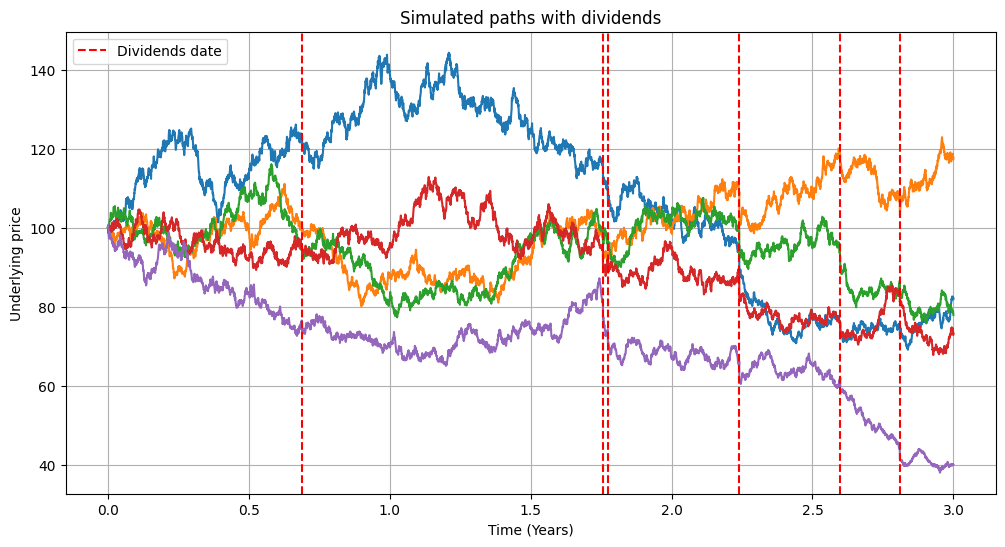

In [7]:
T = 3
ts_paths = np.linspace(0,T,5000)
n=6
ts_divs = np.sort(np.random.uniform(low=0., high=T, size=n))
divs_value = np.column_stack((np.random.uniform(0.,0.05,n), np.full(n, 2)))
n_paths = 5
S0 = 100
r = 0.1
vol = 0.2
q = 0 
paths = simulate_prices_with_discrete_div(n_paths, ts_paths, S0, r, q, vol, ts_divs, divs_value, plot=True, divs_comparison=False)

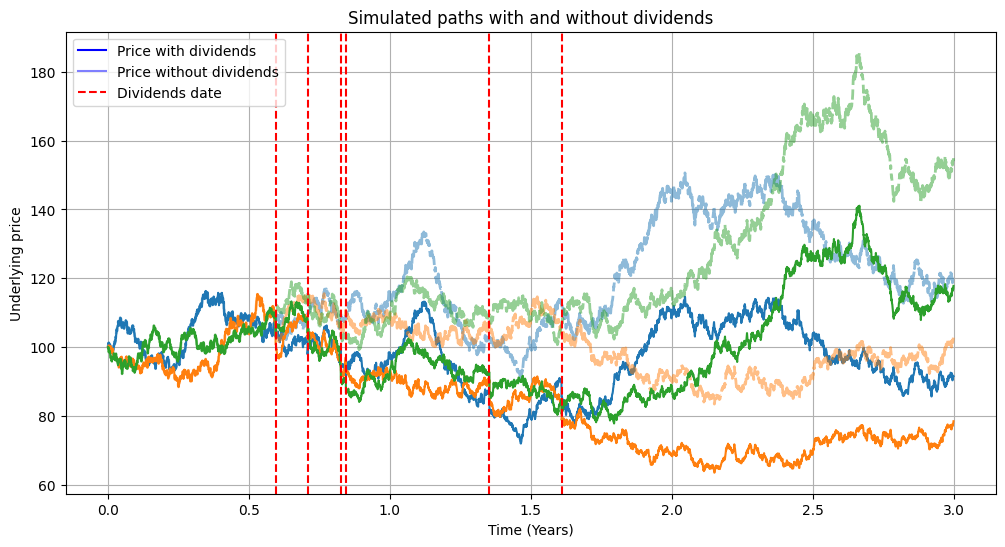

In [8]:
T = 3
ts_paths = np.linspace(0,T,5000)
n=6
ts_divs = np.sort(np.random.uniform(low=0., high=T, size=n))
divs_value = np.column_stack((np.random.uniform(0.,0.05,n), np.full(n, 2)))
n_paths = 3
S0 = 100
r = 0.1
vol = 0.2
q = 0 
paths = simulate_prices_with_discrete_div(n_paths, ts_paths, S0, r, q, vol, ts_divs, divs_value, plot=True, divs_comparison=True)

<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">5.2. Pricing call options for multiple dividend dates and strikes<h1>

<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>

In [9]:
payoff_id = "Call"
S0 = 100
r = 0.06
q = 0.
T = 3
vol = 0.25
fixed_divs = 2
proportionnal_divs = 0.02
n_paths = 500000
diff = 1

t_list = [0.1, 0.5,0.9]
K_list = [40,60,80,100,120,180,250]
ts_paths = np.linspace(0,T,30)
t = 0.1
K = 90
n_paths_list = [100, 1000, 10000, 100000, 300000,500000,750000, 1000000]

In [10]:
build_summary_table(t_list, K_list, payoff_id, n_paths, ts_paths, S0, r, q, vol,T,  diff, fixed_divs, proportionnal_divs, rng = None, digits=3)

t,K,MC full paths (±error),Variance,Time,,MC last price (±error),Variance,Time,,Taylor 3,Time,,Taylor 2,Time,,Taylor 1,Time
0.10,40,55.300 (±3.389e-04),1.49e-02,2.177s,,55.307 (±3.555e-04),1.64e-02,0.586s,,55.323,4.435s,,55.323,3.360s,,55.311,0.276s
,60,39.865 (±2.319e-04),7.00e-03,1.753s,,39.906 (±3.429e-04),1.53e-02,0.395s,,39.875,0.012s,,39.875,0.004s,,39.863,0.001s
,80,27.151 (±5.031e-04),3.29e-02,1.505s,,27.160 (±3.300e-04),1.42e-02,0.351s,,27.147,0.011s,,27.147,0.003s,,27.141,0.001s
,100,17.719 (±2.510e-04),8.20e-03,1.792s,,17.777 (±2.184e-04),6.21e-03,0.353s,,17.763,0.013s,,17.763,0.003s,,17.761,0.001s
,120,11.333 (±2.243e-04),6.55e-03,1.766s,,11.338 (±2.804e-04),1.02e-02,0.374s,,11.350,0.021s,,11.350,0.005s,,11.346,0.002s
,180,2.834 (±1.529e-04),3.04e-03,1.580s,,2.821 (±1.122e-04),1.64e-03,0.441s,,2.827,0.014s,,2.827,0.006s,,2.820,0.002s
,250,0.585 (±5.636e-05),4.13e-04,1.608s,,0.589 (±5.555e-05),4.02e-04,0.389s,,0.579,0.013s,,0.579,0.005s,,0.574,0.001s
0.50,40,55.453 (±4.385e-04),2.50e-02,1.669s,,55.466 (±4.064e-04),2.15e-02,0.387s,,55.463,0.012s,,55.463,0.003s,,55.455,0.001s
,60,40.037 (±3.825e-04),1.90e-02,1.424s,,40.095 (±4.037e-04),2.12e-02,0.362s,,40.047,0.010s,,40.047,0.003s,,40.039,0.001s
,80,27.328 (±2.996e-04),1.17e-02,1.452s,,27.311 (±2.237e-04),6.51e-03,0.364s,,27.345,0.010s,,27.344,0.003s,,27.340,0.001s


<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">5.3. Convergence of Methods <h1>

<div style="background-color: rgb(0, 62, 92); height:2px; margin-top:20px; margin-bottom:20px;"></div>

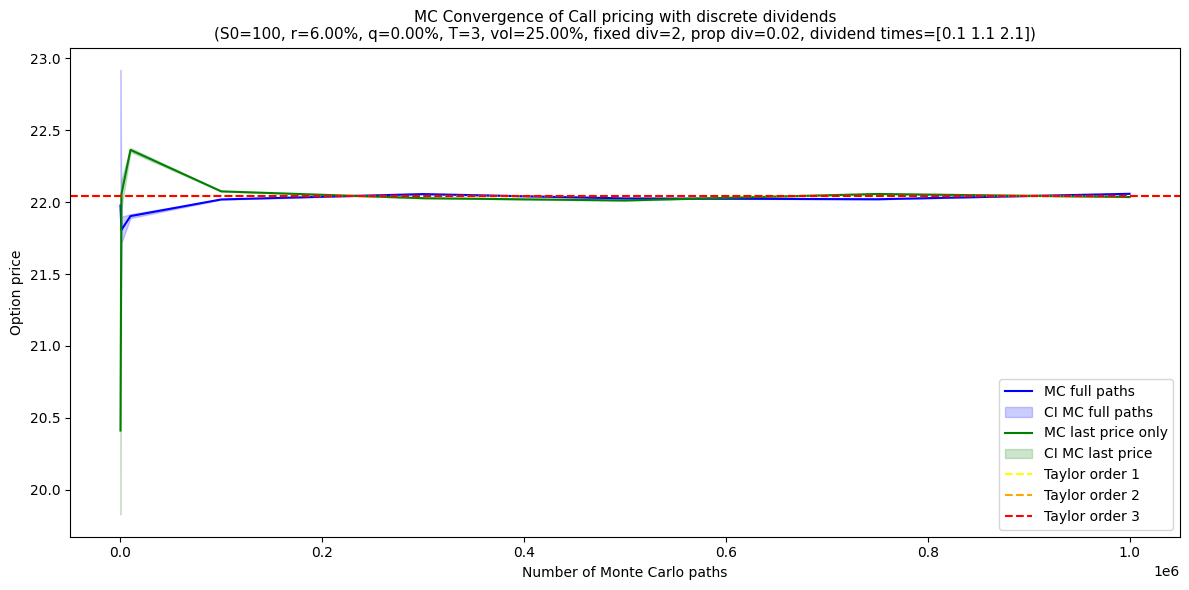

In [11]:
print_convergence(n_paths_list, t, K, payoff_id, ts_paths, S0, r, q, vol, T, diff, fixed_divs, proportionnal_divs, rng = None)